In [22]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [23]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [24]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, null

In [25]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [26]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [27]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [28]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [29]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [30]:
# Find the most recent date in the data set.
most_recent_date=session.query(func.max(Measurement.date)).all()
    
most_recent_date

[('2017-08-23')]

In [44]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

max_date = np.ravel(most_recent_date)[0]

# Calculate the date one year from the last date in data set.

max_date_2 = dt.datetime.strptime(max_date, '%Y-%m-%d')
max_date_2_ly = max_date_2 - dt.timedelta(days=365)
print (max_date_2_ly)

# Perform a query to retrieve the data and precipitation scores

results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= max_date_2_ly).\
    filter(Measurement.prcp != "None").\
    order_by(Measurement.date.asc()).all()
#results


2016-08-23 00:00:00


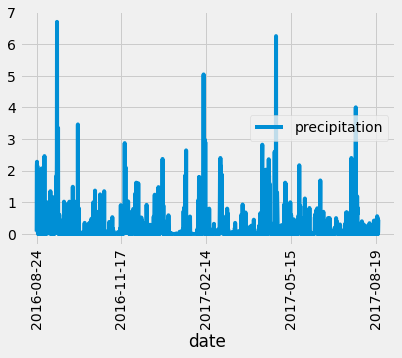

In [45]:
# Save the query results as a Pandas DataFrame and set the index to the date column

prcp_df = pd.DataFrame(results, columns=['date', 'precipitation'])
prcp_df.set_index('date', inplace=True,)
#print(prcp_df)

# Sort the dataframe by date
# it is already sorted by date 
# Use Pandas Plotting with Matplotlib to plot the data

prcp_df.plot(y='precipitation', rot=90, use_index=True)
#plt.xticks(10)

plt.show()


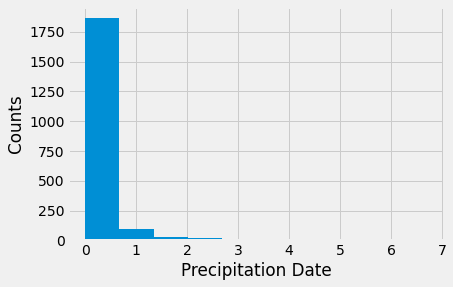

The lower quartile of precipitation is: 0.0
The upper quartile of precipitation is: 0.13
The interquartile range of precipitation is: 0.13
The the median of precipitation is: 0.02 
Values below -0.195 could be outliers.
Values above 0.325 could be outliers.


,precipitation
date,
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15
2016-08-24,1.45
...,...
2017-08-15,0.42
2017-08-16,0.42
2017-08-21,0.56


In [40]:
# Use Pandas to calcualte the summary statistics for the precipitation data

plt.hist(prcp_df)
plt.xlabel('Precipitation Date')
plt.ylabel('Counts')
plt.show()

quartiles =  prcp_df['precipitation'].quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"The lower quartile of precipitation is: {lowerq}")
print(f"The upper quartile of precipitation is: {upperq}")
print(f"The interquartile range of precipitation is: {iqr}")
print(f"The the median of precipitation is: {quartiles[0.5]} ")

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

outlier_precipitation = prcp_df.loc[(prcp_df['precipitation'] < lower_bound) | (prcp_df['precipitation'] > upper_bound)]
outlier_precipitation

# Exploratory Station Analysis

In [34]:
# Design a query to calculate the total number stations in the dataset

total_number_stations = session.query(Station.station).\
    group_by(Station.station).count()


total_number_stations

9

In [35]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
results = session.query(Measurement.station,func.count(Measurement.station)).\
        group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

most_active_station = session.query(Measurement.station,func.count(Measurement.station)).\
        group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()


most_active_station[0]


'USC00519281'

In [36]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
lowest_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == most_active_station[0]).all()
highest_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == most_active_station[0]).all()
average_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station[0]).all()


print(lowest_temp)
print(highest_temp)
print(average_temp)

[(54.0,)]
[(85.0,)]
[(71.66378066378067,)]


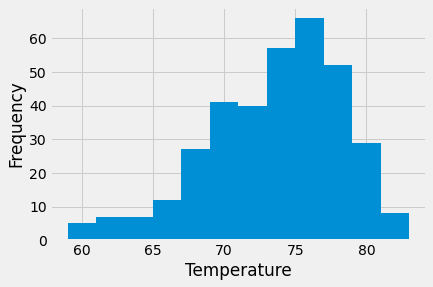

In [39]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temperatures = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station[0]).\
    filter(Measurement.date >= max_date_2_ly).order_by(Measurement.date.asc()).all()
temp_df = pd.DataFrame(temperatures, columns=['temperatures'])

plt.hist(temp_df, bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

# Close session

In [38]:
# Close Session
session.close()